In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

MNIST dataset have images that have size (28,28) therefore we resize them into (32,32). We also Normalize pixels from [0,1] to [-1,1]. We do that so we can get negative gradients. If we had only [0,1] then gradient would always be positive and it would screw with our optimization.

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
BATCH_SIZE = 64
SHUFFLE = True

In [5]:
dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = SHUFFLE)

For a sake of simplicity i will hardcode the layers sizes etc

In [7]:
import torch.nn as nn
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.C1 = nn.Conv2d(in_channels = 1,out_channels = 6, kernel_size = (5,5))
        self.S2 = nn.AvgPool2d(kernel_size=(2,2),stride=2)
        self.C3 = nn.Conv2d(in_channels = 6,out_channels = 16, kernel_size = (5,5))
        self.S4 = nn.AvgPool2d(kernel_size = (2,2), stride = 2)
        self.L5 = nn.Linear(400,120)
        self.L6 = nn.Linear(120,84)
        self.Output = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.C1(x)
        x = torch.tanh(x)
        x = self.S2(x)

        x = self.C3(x)
        x = torch.tanh(x)
        x = self.S4(x)

        x = x.view(-1,400)

        x = self.L5(x)
        x = torch.tanh(x)
        x = self.L6(x)
        x = torch.tanh(x)
        x = self.Output(x)
        return x
        
        
        

In [34]:
import torch.optim as optim
model = LeNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [17]:
EPOCHS = 15

In [35]:
for epoch in range (EPOCHS):
    total_loss = 0.0
    for step, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        for p in model.parameters():
            p.grad = None

        pred = model(x_batch)
        loss = loss_function(pred,y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch={epoch+1} | loss = {avg_loss:.4f}')
            

Epoch=1 | loss = 0.3802
Epoch=2 | loss = 0.1033
Epoch=3 | loss = 0.0697
Epoch=4 | loss = 0.0525
Epoch=5 | loss = 0.0441
Epoch=6 | loss = 0.0373
Epoch=7 | loss = 0.0321
Epoch=8 | loss = 0.0277
Epoch=9 | loss = 0.0242
Epoch=10 | loss = 0.0217


In [21]:
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False,
                                          transform=transform)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=64, 
                         shuffle=False)

In [27]:
def model_eval(loader,model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
    model_eval(test_loader,model)
    acc = 100 * correct / total



    print(f'Dokładność modelu na zbiorze testowym: {acc:.2f}%')

In [28]:
model_eval(test_loader,model)

KeyboardInterrupt: 

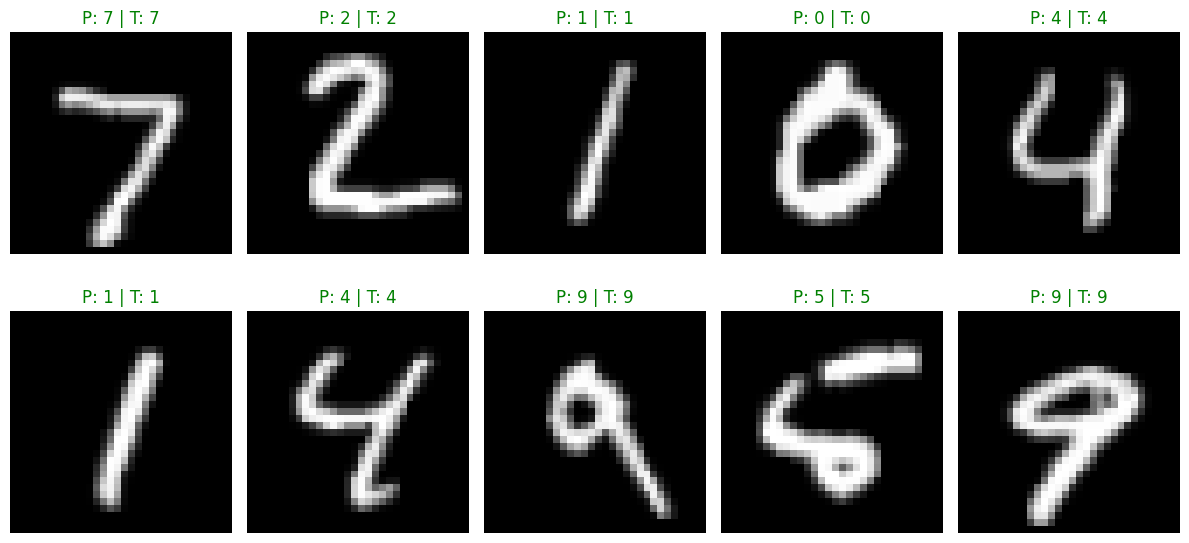

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, num_images=10):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    images = images.to(device)
    labels = labels.to(device)
    

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()
    rows = 2
    cols = num_images // rows
    fig = plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        ax = fig.add_subplot(rows, cols, i+1)
        img = images[i] / 2 + 0.5 
        img = np.transpose(img.numpy(), (1, 2, 0)) 
        img = img.squeeze() 
        
        ax.imshow(img, cmap='gray')
        color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_title(f"P: {preds[i]} | T: {labels[i]}", color=color)
        ax.axis('off') 
        
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, num_images=10)

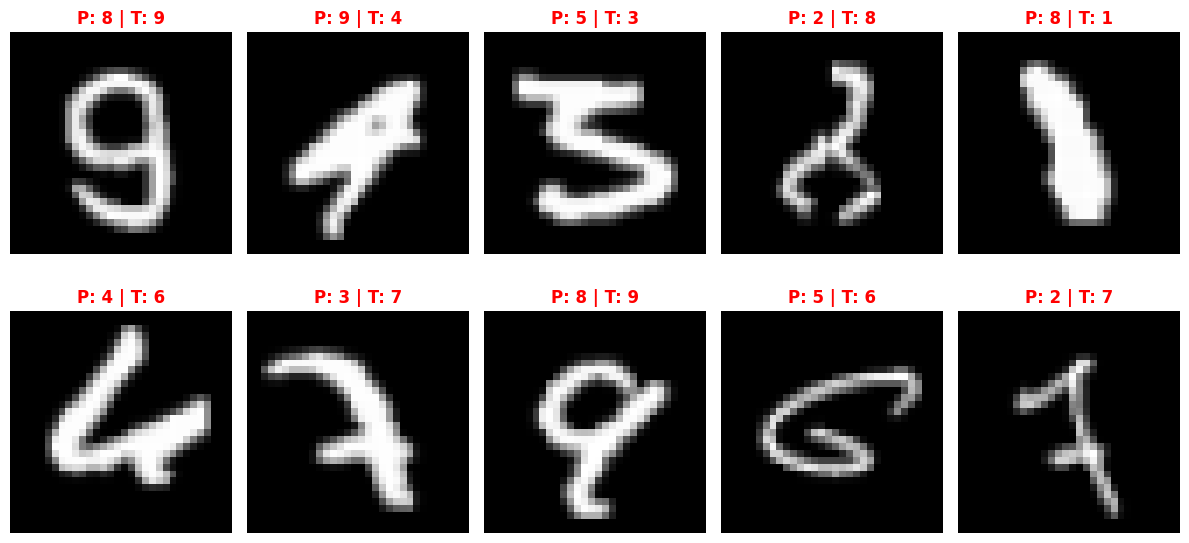

In [37]:
def show_mistakes(model, loader, num_errors=10):
    mistakes = [] 
    model.eval()  
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
           
            for i in range(len(labels)):
                if preds[i] != labels[i]: 
                    mistakes.append((images[i], preds[i], labels[i]))
                

                if len(mistakes) == num_errors:
                    break
            
            if len(mistakes) == num_errors:
                break
    
    fig = plt.figure(figsize=(12, 6))
    for idx, (img, pred, label) in enumerate(mistakes):
        ax = fig.add_subplot(2, 5, idx+1)
        
        img = img.cpu() / 2 + 0.5
        img = img.squeeze()
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f"P: {pred.item()} | T: {label.item()}", color='red', fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Wywołanie
show_mistakes(model, test_loader, num_errors=10)